### 0. Imports and setup

In [2]:
from src.dataset import Colored3DMNIST, DataLoader
from torchvision import transforms, datasets
from IPython.display import clear_output
from src.coloring import random_color, add_dimension
from mpl_toolkits.mplot3d import Axes3D
from src.nn import UNet, ResNet_D
from src.plot import plot_img_3D
from src.plot import plot_img
from pathlib import Path
from tqdm import tqdm

import torch.nn.functional as F
import matplotlib.pyplot as plt
import src.data as data
import torch.nn as nn
import numpy as np
import torchvision
import torch
import gc

In [3]:
if torch.cuda.is_available():
    torch.cuda.set_device(f"cuda:0")
torch.manual_seed(0)
np.random.seed(0)

### 1. Getting the data ready

In [4]:
BATCH_SIZE = 16
TRANSFORM_3D = transforms.ToTensor()

x_train_a = np.load(file='./data/x_train_a_c.npy')
mnist_train_a = Colored3DMNIST(x_train_a)
mnist_loader_a = torch.utils.data.DataLoader(mnist_train_a, batch_size=BATCH_SIZE, shuffle=True)
                                             
x_train_b = np.load(file='./data/x_train_b_c.npy')
mnist_train_b = Colored3DMNIST(x_train_a)
mnist_loader_b = torch.utils.data.DataLoader(mnist_train_b, batch_size=BATCH_SIZE, shuffle=True)

x_test = np.load(file='./data/x_test_c.npy')
mnist_test = Colored3DMNIST(x_test)
mnist_loader_test = torch.utils.data.DataLoader(mnist_test, batch_size=BATCH_SIZE, shuffle=True)

Let's plot a number:

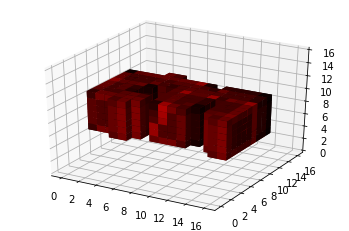

In [5]:
img = next(iter(mnist_loader_test))
plot_img(img[0])
plot_img_3D(img[0])

### 3. Preparation for the training

In [5]:
# Taken from https://github.com/iamalexkorotin/NeuralOptimalTransport/blob/main/src/tools.py
def weights_init_D(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='leaky_relu')
    elif classname.find('BatchNorm') != -1:
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)
        
def weights_init_mlp(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')

In [6]:
f = ResNet_D(16, nc=3).cuda()
f.apply(weights_init_D)

T = UNet(3, 3).cuda()

In [7]:
iter_train_a = iter(mnist_loader_a)
iter_train_b = iter(mnist_loader_b)
iter_test = iter(mnist_loader_test)

def sample_train_a():
    global mnist_loader_a, iter_train_a
    try:
        return next(iter_train_a).float()
    except StopIteration:
        iter_train_a = iter(mnist_loader_a)
        return next(iter_train_a).float()

def sample_train_b():
    global mnist_loader_b, iter_train_b
    try:
        return next(iter_train_b).float()
    except StopIteration:
        iter_train_b = iter(mnist_loader_b)
        return next(iter_train_b).float()

def sample_test():
    global mnist_loader_test, iter_test
    try:
        return next(iter_test).float()
    except StopIteration:
        iter_test = iter(mnist_loader_test)
        return next(iter_test).float()

In [8]:
T_opt = torch.optim.Adam(T.parameters(), lr=1e-5, weight_decay=1e-10)
f_opt = torch.optim.Adam(f.parameters(), lr=1e-4, weight_decay=1e-10)

In [9]:
def save_model(e, t, F, o_t, o_F, l_t, l_F, path):
    torch.save({
                'epoch': e,
                'T_state_dict': t.state_dict(),
                'f_state_dict': F.state_dict(),
                'T_optimizer_state_dict': o_t.state_dict(),
                'f_optimizer_state_dict': o_F.state_dict(),
                'T_loss': l_t,
                'f_loss': l_F
                }, path)

def load_model(F, t, o_t, o_F, path):
    checkpoint = torch.load(path)

    F.load_state_dict(checkpoint["f_state_dict"])
    t.load_state_dict(checkpoint["T_state_dict"])
    o_F.load_state_dict(checkpoint["f_optimizer_state_dict"])
    o_t.load_state_dict(checkpoint["T_optimizer_state_dict"])
    
    return checkpoint["epoch"], F, t, o_F, o_t, checkpoint["T_loss"], checkpoint["f_loss"]

step, f, T, T_opt, f_opt, T_loss, f_loss = load_model(f, T, T_opt, f_opt, "weights/OT_30000.pt")

### 4. Training loop

In [10]:
def sq_cost(X, Y):
  return (X-Y).square().flatten(start_dim=1).mean(dim=1)

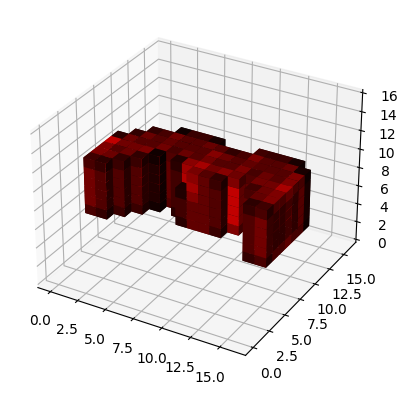

  0%|          | 0/5001 [00:00<?, ?it/s]

T_loss: -127.18041229248047;  f_loss: -5.1982421875


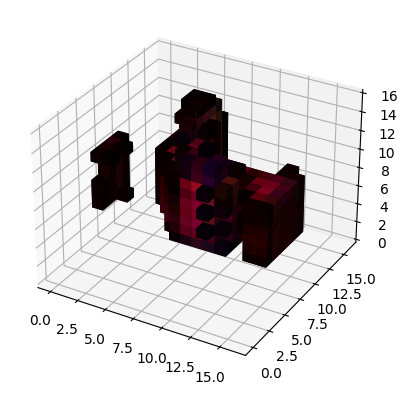

  2%|▏         | 100/5001 [00:39<31:19,  2.61it/s]

T_loss: -1.2311617555053796e+25;  f_loss: -4.354457701534554e+23


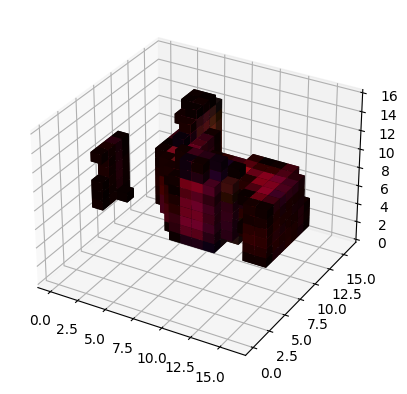

  4%|▍         | 200/5001 [01:18<31:17,  2.56it/s]

T_loss: -2.0596818164278824e+25;  f_loss: -9.627332673638923e+23


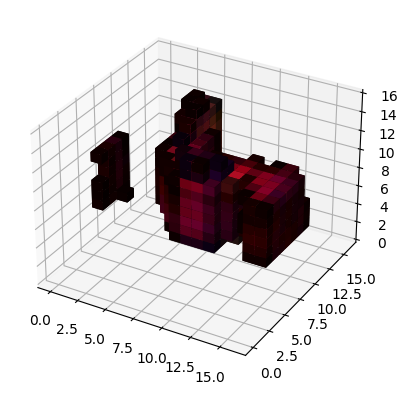

  6%|▌         | 300/5001 [01:58<30:49,  2.54it/s]

T_loss: -2.578348227795471e+25;  f_loss: 1.6951543232815024e+24


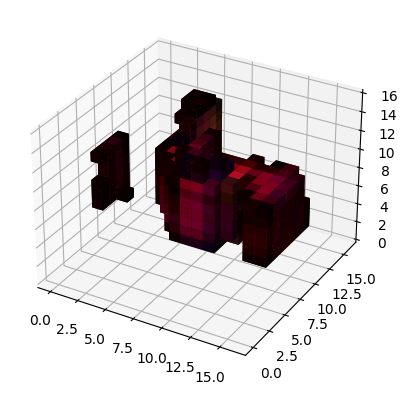

  8%|▊         | 400/5001 [02:37<30:09,  2.54it/s]

T_loss: -2.4694515635051415e+25;  f_loss: -7.356330952294448e+23


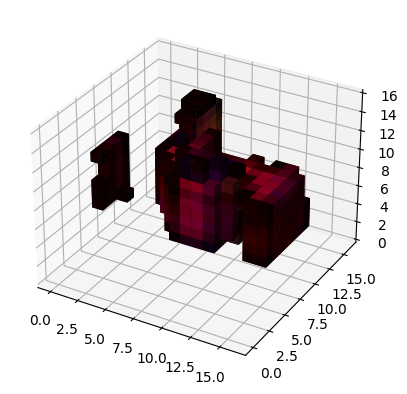

 10%|▉         | 500/5001 [03:17<29:43,  2.52it/s]

T_loss: -2.9663081587700824e+25;  f_loss: 7.42060402033327e+24


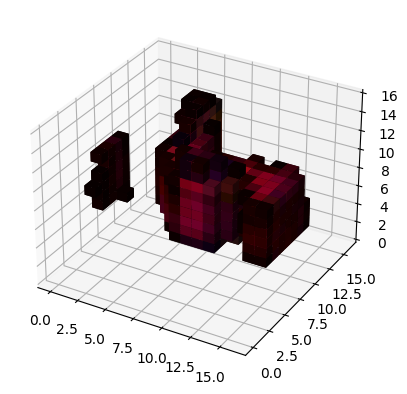

 12%|█▏        | 600/5001 [03:57<28:49,  2.54it/s]

T_loss: -3.3360470877015863e+25;  f_loss: 2.577060875643427e+24


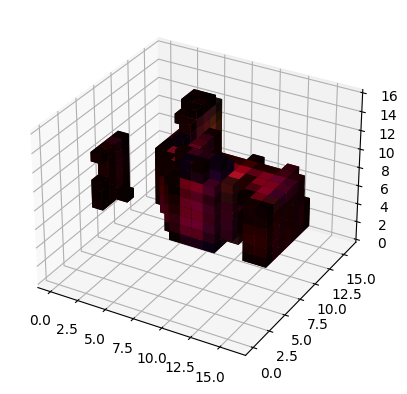

 14%|█▍        | 700/5001 [04:37<28:21,  2.53it/s]

T_loss: -3.471471092307114e+25;  f_loss: 5.68802355916922e+24


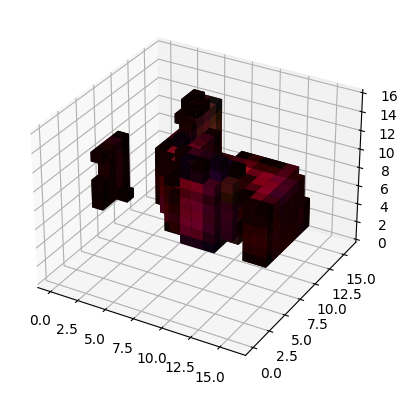

 16%|█▌        | 800/5001 [05:16<27:36,  2.54it/s]

T_loss: -3.8310811446520448e+25;  f_loss: 4.5202777898561386e+24


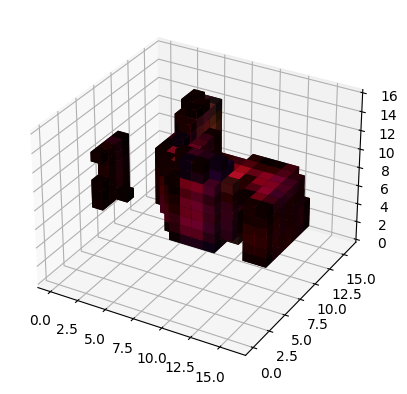

 18%|█▊        | 900/5001 [05:56<26:56,  2.54it/s]

T_loss: -4.2073647477966e+25;  f_loss: 2.992589926804799e+24


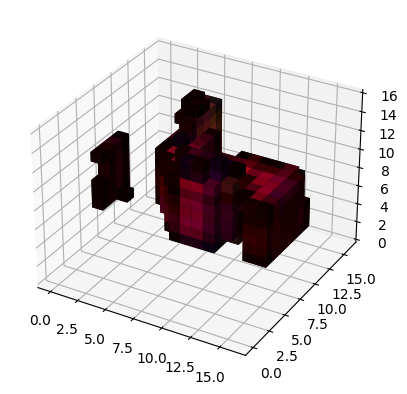

 20%|█▉        | 1000/5001 [06:36<26:26,  2.52it/s]

T_loss: -4.276718971490526e+25;  f_loss: 4.085601018346256e+24


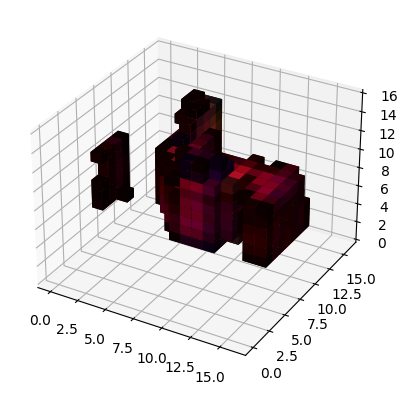

 22%|██▏       | 1100/5001 [07:16<25:46,  2.52it/s]

T_loss: -4.392540543506126e+25;  f_loss: -5.789651283957305e+24


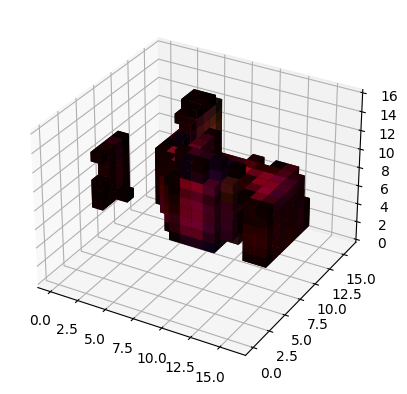

 24%|██▍       | 1200/5001 [07:56<25:06,  2.52it/s]

T_loss: -4.784344775945698e+25;  f_loss: 1.8771176185105918e+25


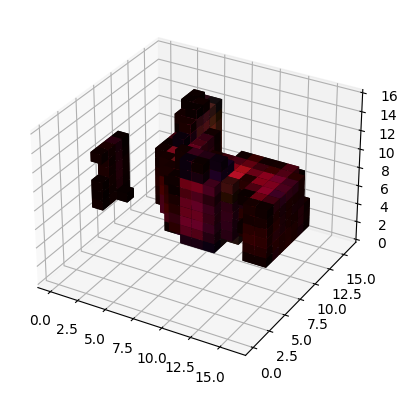

 26%|██▌       | 1300/5001 [08:36<24:17,  2.54it/s]

T_loss: -5.106858425958399e+25;  f_loss: 7.344395908878758e+24


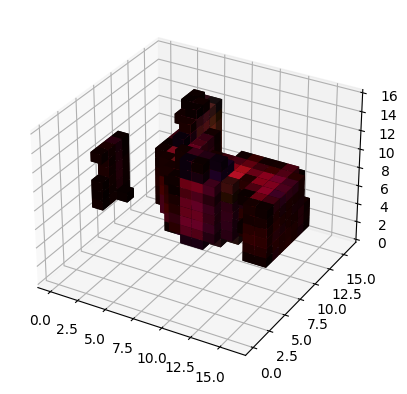

 28%|██▊       | 1400/5001 [09:16<23:36,  2.54it/s]

T_loss: -5.436911260274025e+25;  f_loss: 7.967794401477735e+24


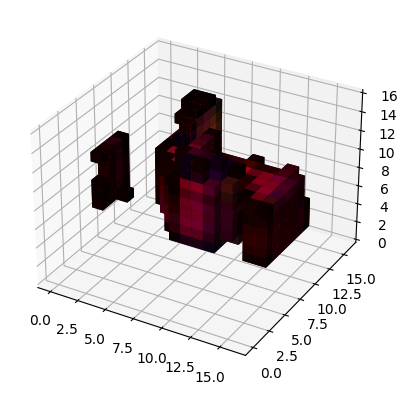

 30%|██▉       | 1500/5001 [09:55<23:07,  2.52it/s]

T_loss: -4.956473650740491e+25;  f_loss: 7.883409770712551e+24


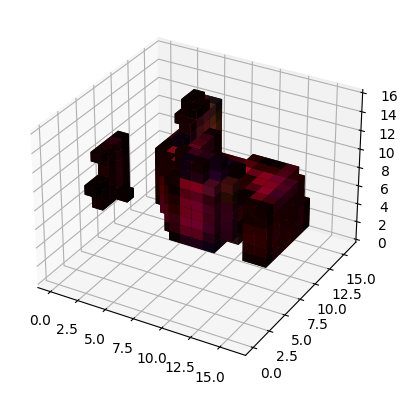

 32%|███▏      | 1600/5001 [10:35<22:21,  2.53it/s]

T_loss: -5.426893755904797e+25;  f_loss: 2.0288236417727792e+24


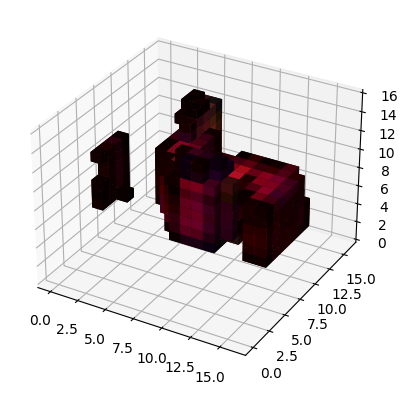

 34%|███▍      | 1700/5001 [11:15<21:40,  2.54it/s]

T_loss: -5.8248619678766e+25;  f_loss: 1.576500253713384e+24


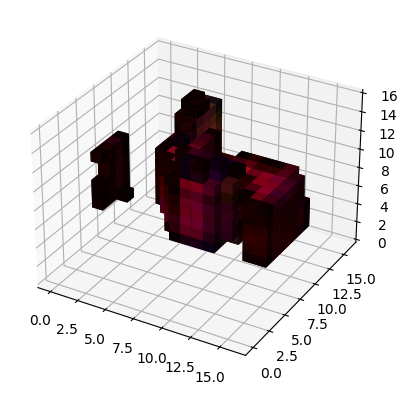

 36%|███▌      | 1800/5001 [11:55<21:04,  2.53it/s]

T_loss: -6.185492125168807e+25;  f_loss: 4.8764890296054885e+23


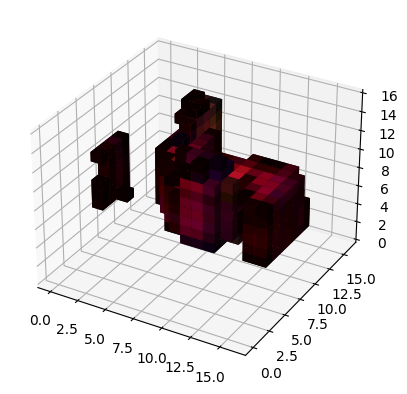

 38%|███▊      | 1900/5001 [12:35<20:18,  2.54it/s]

T_loss: -6.286645768634197e+25;  f_loss: 9.221236826228244e+24


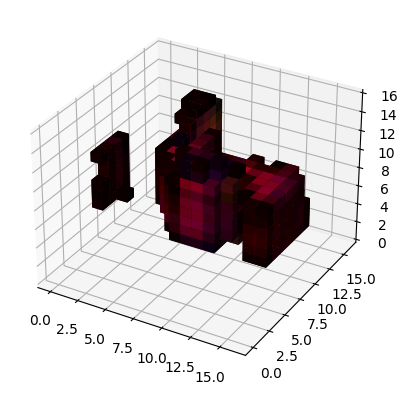

 40%|███▉      | 2000/5001 [13:15<19:45,  2.53it/s]

T_loss: -6.032621190018365e+25;  f_loss: 5.733838353919287e+24


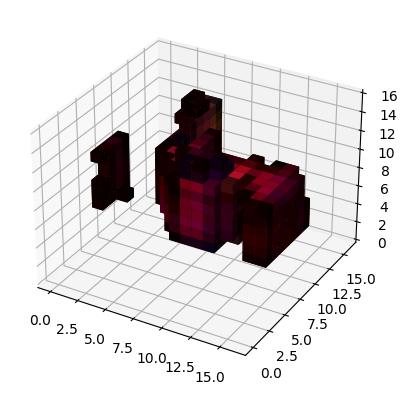

 42%|████▏     | 2100/5001 [13:55<19:02,  2.54it/s]

T_loss: -6.8283321025156685e+25;  f_loss: 1.9124542014581899e+25


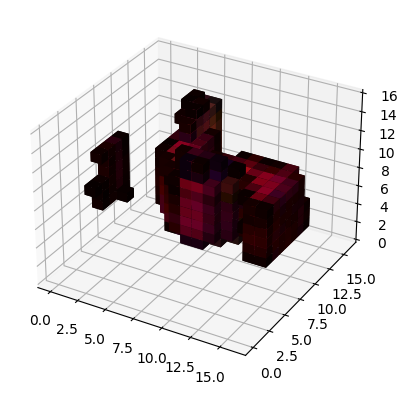

 44%|████▍     | 2200/5001 [14:35<18:20,  2.55it/s]

T_loss: -6.299445964346944e+25;  f_loss: 3.8636290410643e+24


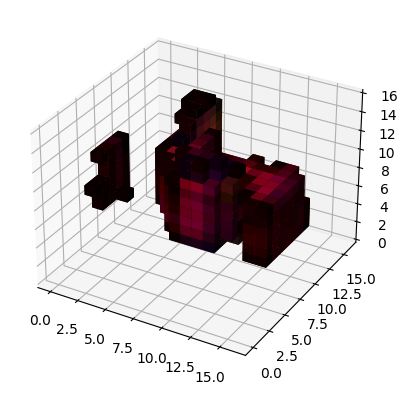

 46%|████▌     | 2300/5001 [15:15<17:50,  2.52it/s]

T_loss: -7.169490799100871e+25;  f_loss: 3.553276407082192e+24


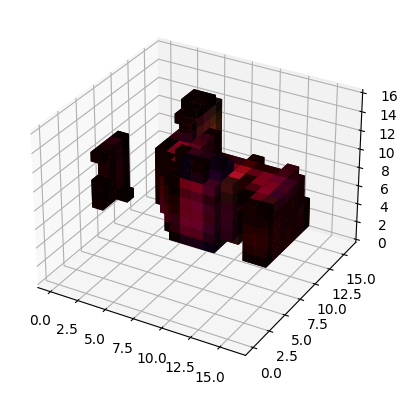

 48%|████▊     | 2400/5001 [15:54<17:13,  2.52it/s]

T_loss: -6.951303171365637e+25;  f_loss: 6.15807657412646e+24


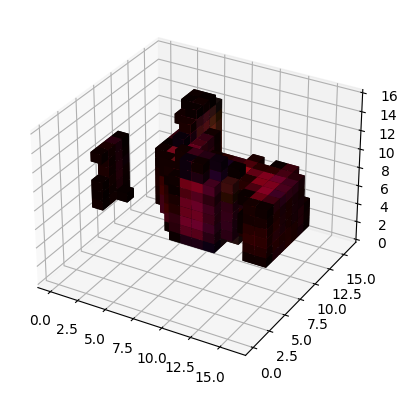

 50%|████▉     | 2500/5001 [16:34<16:27,  2.53it/s]

T_loss: -8.30776236073298e+25;  f_loss: 5.617125804164927e+24


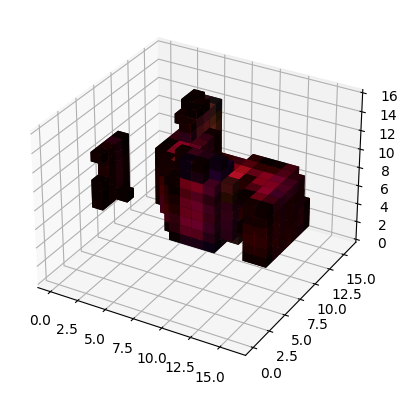

 52%|█████▏    | 2600/5001 [17:14<15:50,  2.52it/s]

T_loss: -7.996932878416567e+25;  f_loss: 1.0093938453297388e+25


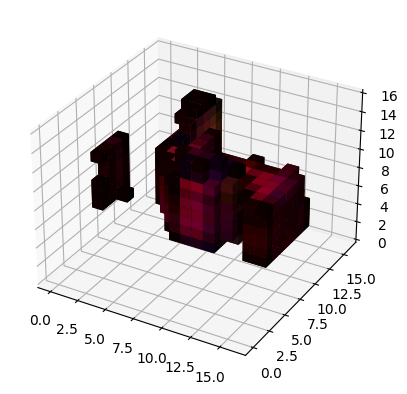

 54%|█████▍    | 2700/5001 [17:54<15:00,  2.56it/s]

T_loss: -7.881166646633188e+25;  f_loss: 6.806534968549571e+24


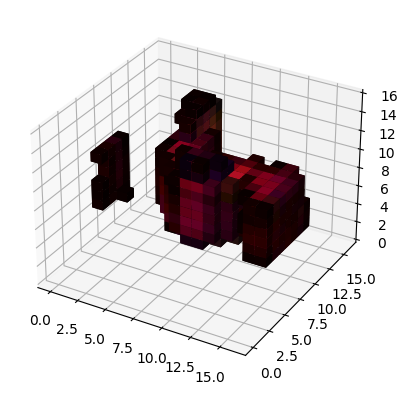

 56%|█████▌    | 2800/5001 [18:34<14:29,  2.53it/s]

T_loss: -8.311748702127309e+25;  f_loss: 1.1485293348428967e+25


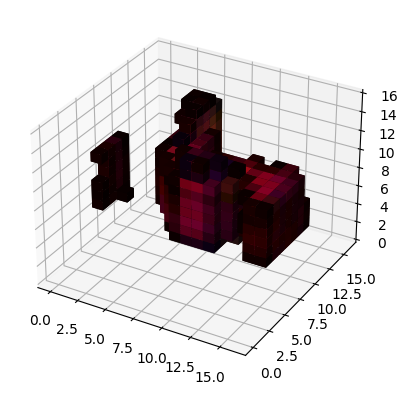

 58%|█████▊    | 2900/5001 [19:14<13:53,  2.52it/s]

T_loss: -8.37208984666682e+25;  f_loss: 2.0581585765359958e+24


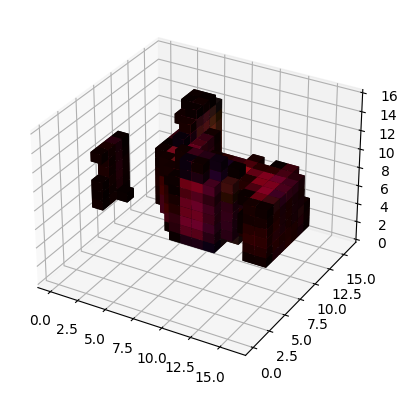

 60%|█████▉    | 3000/5001 [19:54<13:10,  2.53it/s]

T_loss: -8.638046701686731e+25;  f_loss: 3.6310967639687466e+25


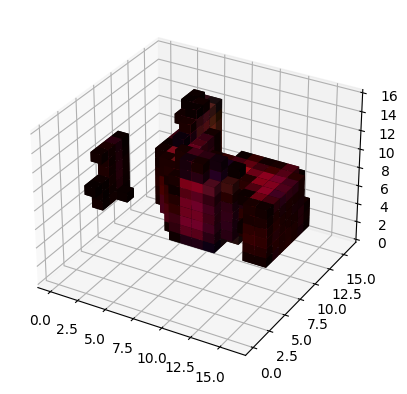

 62%|██████▏   | 3100/5001 [20:34<12:29,  2.53it/s]

T_loss: -9.097125287425919e+25;  f_loss: 1.7199283005724943e+24


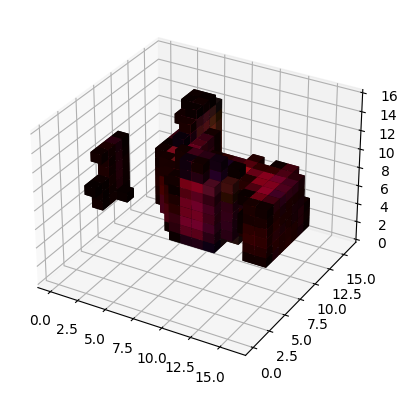

 64%|██████▍   | 3200/5001 [21:14<11:50,  2.53it/s]

T_loss: -9.80558632863479e+25;  f_loss: 1.0352995303696528e+25


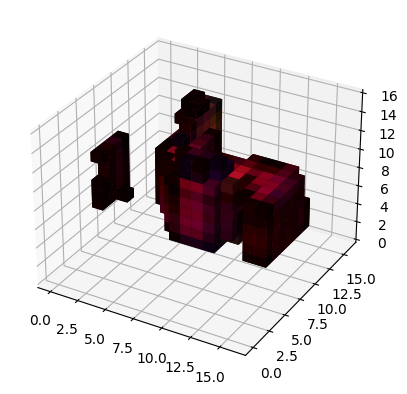

 66%|██████▌   | 3300/5001 [21:54<11:10,  2.54it/s]

T_loss: -9.80783129738856e+25;  f_loss: 7.323689438656019e+24


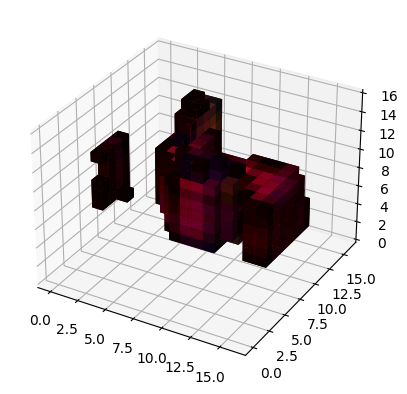

 68%|██████▊   | 3400/5001 [22:33<10:30,  2.54it/s]

T_loss: -9.653520593863165e+25;  f_loss: 2.536012258393405e+24


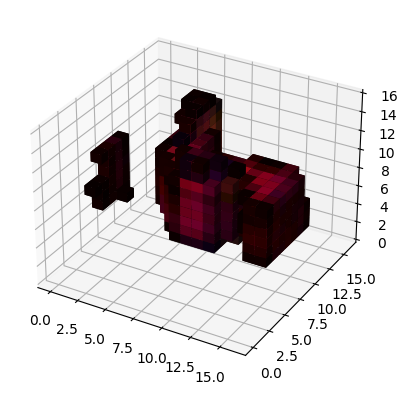

 70%|██████▉   | 3500/5001 [23:13<09:52,  2.53it/s]

T_loss: -9.677637867065132e+25;  f_loss: 2.719050076464788e+23


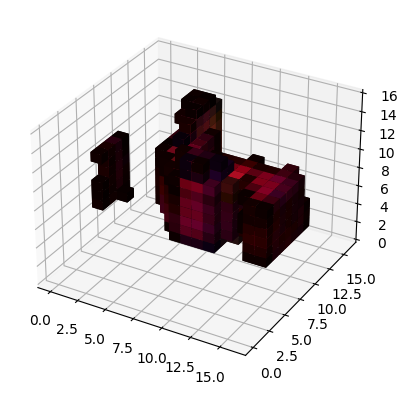

 72%|███████▏  | 3600/5001 [23:53<09:13,  2.53it/s]

T_loss: -1.0952093900327207e+26;  f_loss: 1.3938073897561795e+25


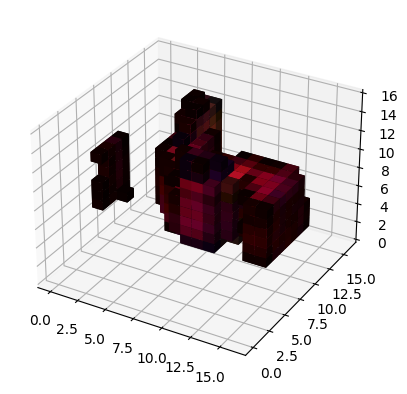

 74%|███████▍  | 3700/5001 [24:33<08:31,  2.54it/s]

T_loss: -1.079172620838521e+26;  f_loss: 9.890683003721219e+24


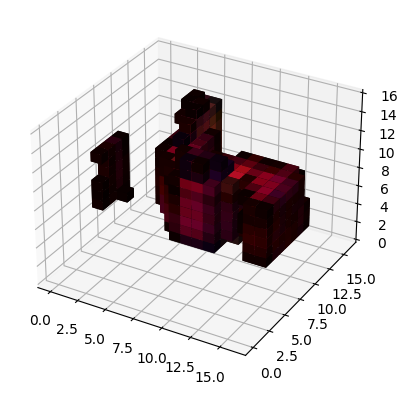

 76%|███████▌  | 3800/5001 [25:13<07:53,  2.54it/s]

T_loss: -1.0347978711645682e+26;  f_loss: 1.1013112040374224e+25


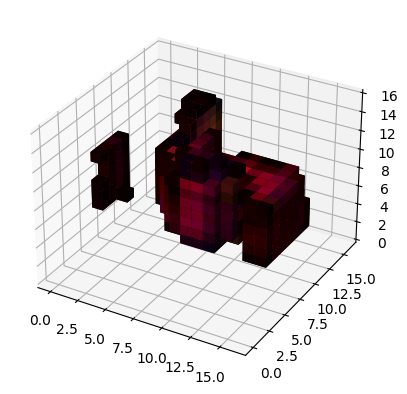

 78%|███████▊  | 3900/5001 [25:53<07:14,  2.53it/s]

T_loss: -1.1064755545082981e+26;  f_loss: 1.5501804392690153e+25


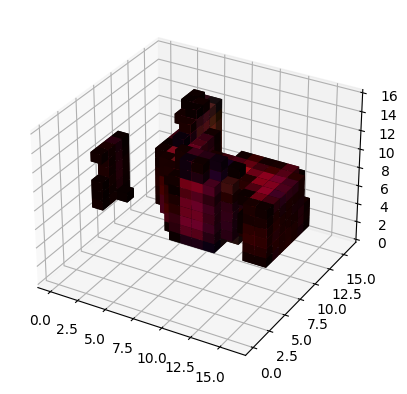

 80%|███████▉  | 4000/5001 [26:33<06:37,  2.52it/s]

T_loss: -1.0088389672680016e+26;  f_loss: 7.465415773374329e+24


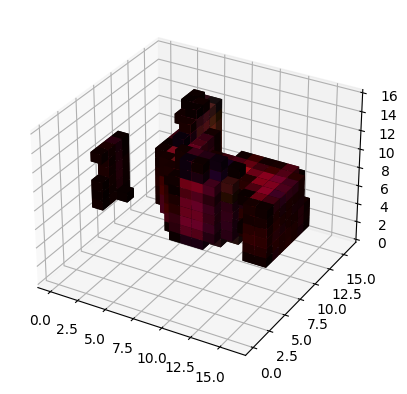

 82%|████████▏ | 4100/5001 [27:13<05:57,  2.52it/s]

T_loss: -1.0411696532687886e+26;  f_loss: 7.828373909768638e+24


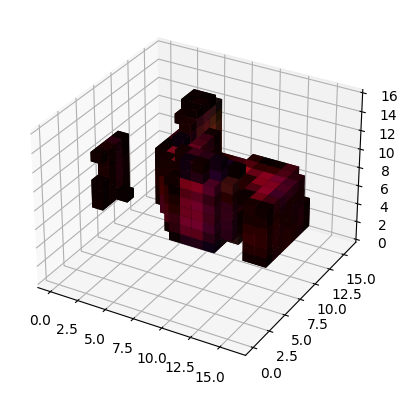

 84%|████████▍ | 4200/5001 [27:53<05:14,  2.54it/s]

T_loss: -1.1644282146251455e+26;  f_loss: -1.142525841984108e+25


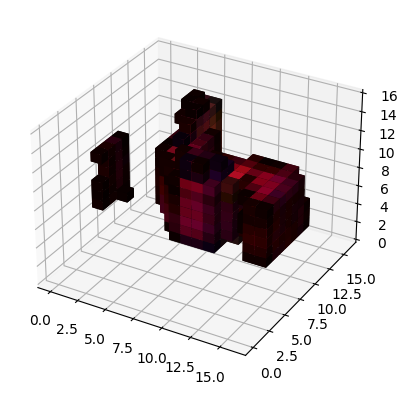

 86%|████████▌ | 4300/5001 [28:33<04:36,  2.54it/s]

T_loss: -1.1549630057734844e+26;  f_loss: 1.1304330789065877e+25


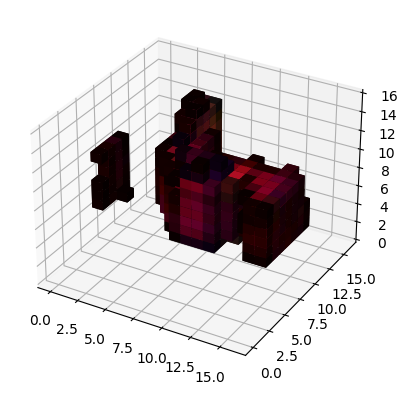

 88%|████████▊ | 4400/5001 [29:13<03:58,  2.52it/s]

T_loss: -1.235512927380626e+26;  f_loss: 2.4618674152635367e+25


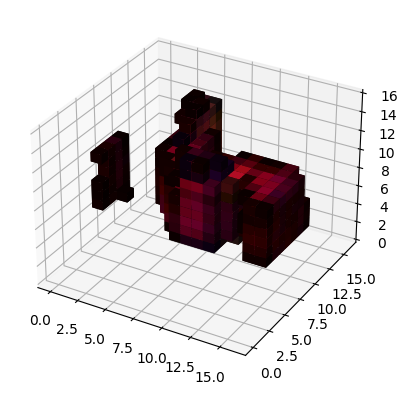

 90%|████████▉ | 4500/5001 [29:53<03:18,  2.53it/s]

T_loss: -1.1014391322075736e+26;  f_loss: 1.132443774010622e+25


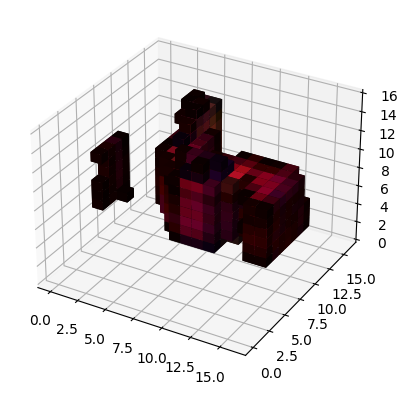

 92%|█████████▏| 4600/5001 [30:33<02:38,  2.53it/s]

T_loss: -1.2165880437005259e+26;  f_loss: 2.2212739110077725e+24


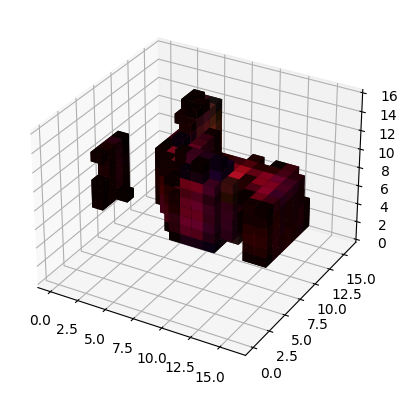

 94%|█████████▍| 4700/5001 [31:13<01:59,  2.53it/s]

T_loss: -1.0892750724642084e+26;  f_loss: 1.1142396046214817e+25


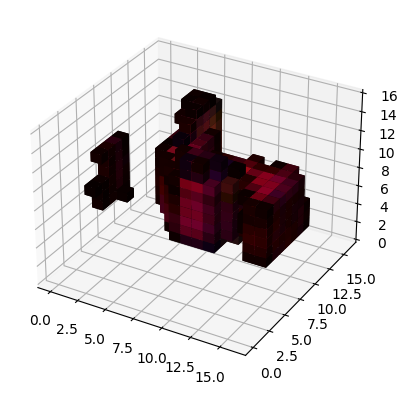

 96%|█████████▌| 4800/5001 [31:53<01:19,  2.53it/s]

T_loss: -1.2619713691067087e+26;  f_loss: 2.270942691763439e+25


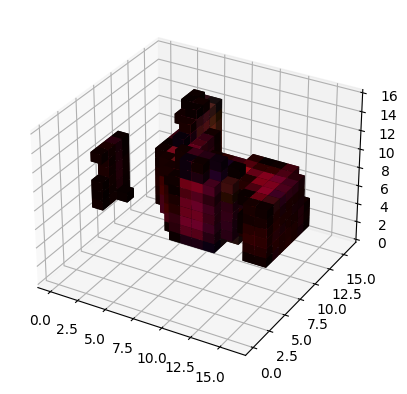

 98%|█████████▊| 4900/5001 [32:33<00:40,  2.52it/s]

T_loss: -1.2459755516843526e+26;  f_loss: -1.015032092655868e+25


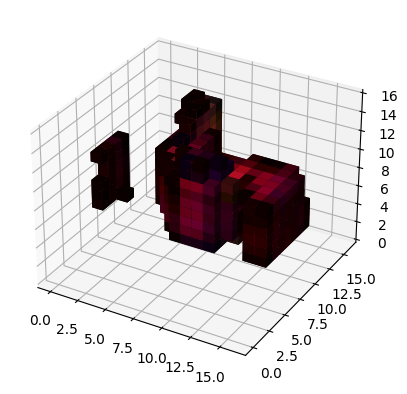

100%|█████████▉| 5000/5001 [33:13<00:00,  2.54it/s]

T_loss: -1.2123541470007281e+26;  f_loss: -8.702140836308039e+24


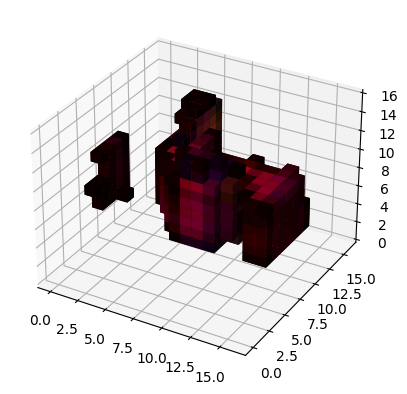

100%|██████████| 5001/5001 [33:14<00:00,  2.51it/s]


In [11]:
test_batch = sample_test()
plot_img(test_batch[0])
f_losses = []
T_losses = []

imgs = []

for step in tqdm(range(5001)):
    # clear_output(wait=True)

    # Training T, freezing f
    T.train(True)
    f.eval()
    
    for i in range(10):
        X = sample_train_a().cuda()

        T_X = T(X)
        T_loss = sq_cost(X, T_X).mean() - f(T_X).mean()
        T_opt.zero_grad()
        T_loss.backward()
        T_opt.step()
    

    # Training f, freezing T
    f.train(True)
    T.eval()

    X = sample_train_a().cuda()
    Y = sample_train_b().cuda()

    with torch.no_grad():
        T_x = T(X)
    
    f_loss = f(T_x).mean() - f(Y).mean()
    f_opt.zero_grad()
    f_loss.backward()
    f_opt.step()

    if not step % 100:
        print(f"T_loss: {T_loss}; ", end="")
        print(f" f_loss: {f_loss}")
        T_X = torch.clip(T(test_batch.cuda())[0].cpu().detach(), min=0, max=1)
        T_X[T_X < np.quantile(T_X, 0.92)] = 0
        plot_img(T_X)

    # Save OT map every 1000 steps
    if not step % 1000:
        save_model(step, T, f, T_opt, f_opt, T_loss, f_loss, f"weights/OT_transfer_30000_unrotated_{step}.pt")

    gc.collect()
    torch.cuda.empty_cache()

In [16]:
test_batch = sample_test().cuda()

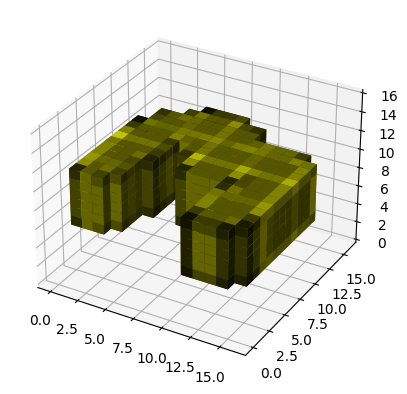

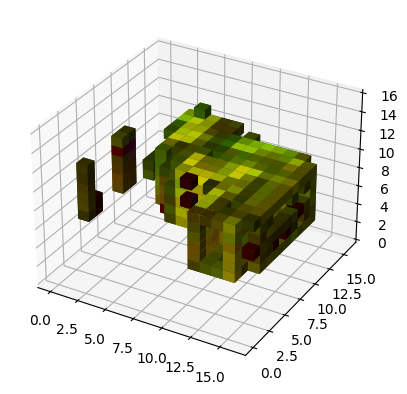

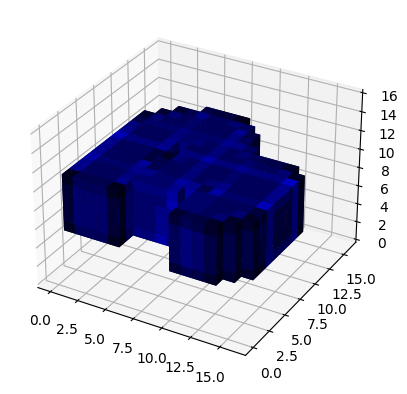

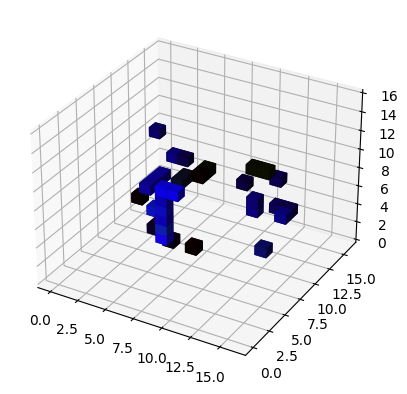

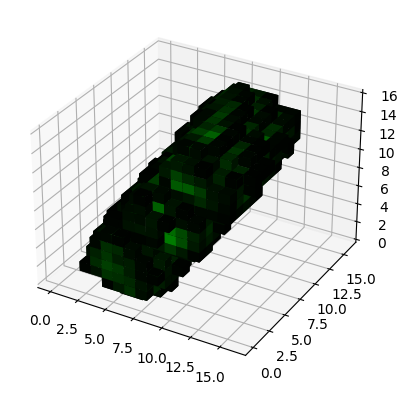

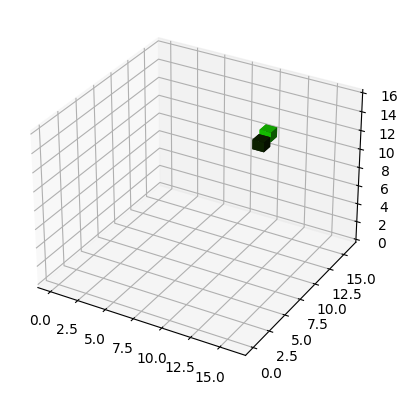

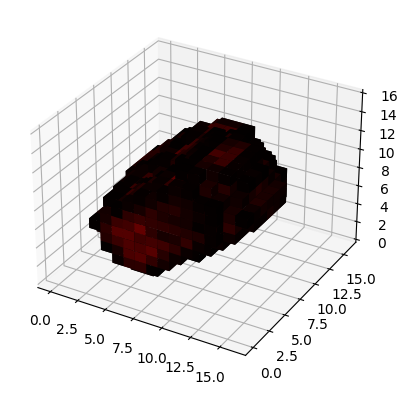

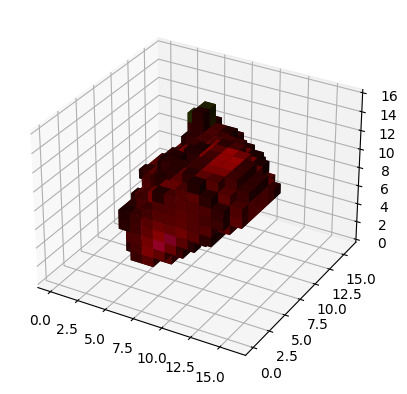

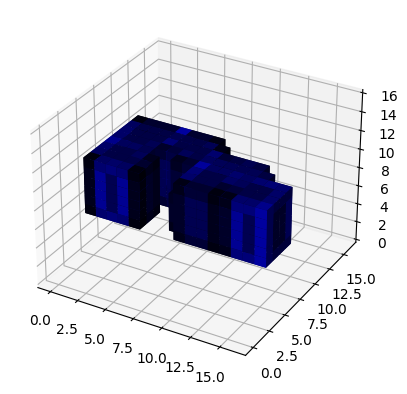

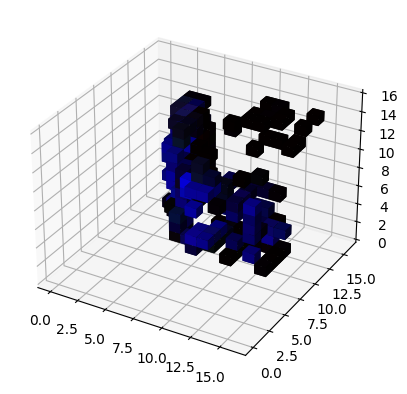

In [17]:
for i in range(5):
    plot_img(test_batch[i].cpu())

    T_X = torch.clip(T(test_batch)[i].cpu().detach(), min=0, max=1)
    T_X[T_X < np.quantile(T_X, 0.92)] = 0
    plot_img(T_X)